In [1]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split, ParameterGrid
import altair as alt
from time import time, sleep
from tqdm import tqdm
from multiprocessing import Pool
import pickle

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants
DATA_DIR = 'ml-100k'

In [3]:
df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=250, subsample_top_items=250)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [28]:
len(df_num)/(p*q)

0.49744

In [5]:
df_train, df_val = train_test_split(df_num, test_size=0.1, random_state=seed)

In [6]:
print(f'''Dataframe dimensions:
    df_train: {df_train.shape}
    df_val: {df_val.shape}
    ''')

Dataframe dimensions:
    df_train: (27981, 3)
    df_val: (3109, 3)
    


# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Normal
Not as simple as the simple model above, this is the analogous to the "regular" way when doing regression.

$$ U_{ij} \sim N(\mu_U, \sigma_U) $$
$$ V_{ij} \sim N(\mu_V, \sigma_V) $$
$$ X_{ij}\sim N((UV_{ij}), \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$\mu_U, \sigma_U, \mu_V, \sigma_V, a_\beta, b_\beta$

## Model 2: Non-negative Matrix Factorization

$$ U_{ij}\sim Gamma(a_U, b_U) $$
$$ V_{ij}\sim Gamma(a_V, b_V) $$
$$ X_{ij}\sim Normal((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$a_U, b_U, a_V, b_V, a_\beta, b_\beta$

## Model 3: ARD

$$ U_{ij} \sim N(\mu_U, \alpha_j) $$
$$ V_{ij} \sim N(\mu_V, \alpha_j) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$
$$ \alpha_{j} \sim Gamma(a_\alpha, b_\alpha) $$

User defined variables:
$\mu_U, \mu_V, a_\alpha, b_\alpha, a_\beta, b_\beta$

In [7]:
models = [
    StanClasses.NormalFactorizer,
    StanClasses.NonNegativeFactorizer,
    StanClasses.ARD_Factorizer
]

init_kwargs = {'n_components':[3,5,10,15,20]}
static_kwargs = {'chains':1, 'iter':1000, 'control':{'max_treedepth':15}}

t0 = time()
# hist = utils.fit_and_evaluate_models(
#     models=models,
#     X_train=df_train,
#     X_val=df_val,
#     candidate_kwargs=init_kwargs,
#     static_kwargs=static_kwargs
# )
evaltime = time()-t0

In [8]:
df_hist = pd.read_pickle('histpickle_withmodels3.pkl')
df_hist.sort_values('val_mae', inplace=True)

In [9]:
best_model = df_hist['model'].values[0]
best_params = df_hist['params'].values[0].copy()

In [10]:
print(best_model)
print(best_params)

{'n_components': 10}


In [11]:
df_hist

,model,params,fit_time,train_mae,val_mae
7,<StanClasses.ARD_Factorizer object at 0x7f2b58...,{'n_components': 10},5140.227147,0.650904,0.682541
1,<StanClasses.NormalFactorizer object at 0x7f2b...,{'n_components': 5},1559.373360,0.648885,0.682633
0,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 3},1523.805643,0.649970,0.683012
9,<StanClasses.ARD_Factorizer object at 0x7f2b17...,{'n_components': 20},6256.760215,0.632622,0.687372
3,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 15},2177.143758,0.632095,0.693943
6,<StanClasses.NormalFactorizer object at 0x7f2b...,{'n_components': 5},4159.630697,0.628486,0.699467
8,<StanClasses.ARD_Factorizer object at 0x7f2b17...,{'n_components': 15},5380.681895,0.598903,0.707043
2,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 10},1982.613290,0.605457,0.711533
4,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 20},2594.418423,0.592572,0.723877
10,<StanClasses.ARD_Factorizer object at 0x7f2b16...,{'n_components': 3},6514.166563,0.576058,0.725964


In [12]:
df_hist

,model,params,fit_time,train_mae,val_mae
7,<StanClasses.ARD_Factorizer object at 0x7f2b58...,{'n_components': 10},5140.227147,0.650904,0.682541
1,<StanClasses.NormalFactorizer object at 0x7f2b...,{'n_components': 5},1559.373360,0.648885,0.682633
0,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 3},1523.805643,0.649970,0.683012
9,<StanClasses.ARD_Factorizer object at 0x7f2b17...,{'n_components': 20},6256.760215,0.632622,0.687372
3,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 15},2177.143758,0.632095,0.693943
6,<StanClasses.NormalFactorizer object at 0x7f2b...,{'n_components': 5},4159.630697,0.628486,0.699467
8,<StanClasses.ARD_Factorizer object at 0x7f2b17...,{'n_components': 15},5380.681895,0.598903,0.707043
2,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 10},1982.613290,0.605457,0.711533
4,<StanClasses.NonNegativeFactorizer object at 0...,{'n_components': 20},2594.418423,0.592572,0.723877
10,<StanClasses.ARD_Factorizer object at 0x7f2b16...,{'n_components': 3},6514.166563,0.576058,0.725964


In [13]:
for model in df_hist['model']:
    summary = model.stanfit.summary()['summary']
    print(type(model).__name__, summary[:,-1].min(), summary[:,-1].max(), summary[:,-1].mean(), summary[:,-1].std())

ARD_Factorizer 0.9979980016964524 1.6704661137031347 1.0591396312384707 0.08839714487024494
NormalFactorizer 0.9979983129549672 2.904610329928807 1.3045865701395891 0.3848242559637333
NonNegativeFactorizer 0.9979979975340515 1.0400777814262623 1.0004943601970058 0.0035423251358299404
ARD_Factorizer 0.9979980195065529 2.1999019804087583 1.202425244264142 0.2846879182108176
NonNegativeFactorizer 0.9979979964251299 1.420034861099358 1.0186603114610906 0.03504577307427713
NormalFactorizer 0.9979990405774218 2.2997491784378723 1.3073042118457037 0.2547693294324264
ARD_Factorizer 0.9979979970391538 2.3787385408611543 1.1465479575122162 0.1996346108499034
NonNegativeFactorizer 0.9979979959901097 1.5442107711582236 1.0210021551505217 0.04157297462902059
NonNegativeFactorizer 0.9979979960225032 1.8263822228587796 1.0311574097056357 0.06772603625535772
ARD_Factorizer 0.9979979962043851 2.1073197037389924 1.070972184761609 0.1019308766152477
NonNegativeFactorizer 0.9979979960030698 2.479752640166

In [14]:
df_hist.fit_time.mean()

8977.689910523097

In [15]:
best_params.update(static_kwargs)
final_model = type(best_model)(**best_params)

In [16]:
df_full, _, _ = utils.get_ml100k_data(DATA_DIR)
df_full[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df_full.drop('timestamp', axis='columns', inplace=True)

df_full_train, df_test = train_test_split(df_full, test_size=0.05, random_state=seed)

In [17]:
# final_model.fit(df_full_train)

In [18]:
with open('final_dict.pkl', 'rb') as f:
    final_dict = pickle.load(f)

In [19]:
final_dict

{'model': <StanClasses.ARD_Factorizer at 0x7f2b18c9bf28>,
 'params': {'n_components': 10,
  'chains': 1,
  'iter': 1000,
  'control': {'max_treedepth': 15}},
 'fit_time': 77645.62998747826,
 'train_mae': 0.6267519055847237,
 'test_mae': 0.7625644897334257}

In [20]:
df_hist.columns

Index(['model', 'params', 'fit_time', 'train_mae', 'val_mae'], dtype='object')

In [21]:
# final_model_object, fit_time, train_mae, test_mae =\
#     utils.fit_and_evaluate((type(best_model), best_params, df_full_train, df_test))

# hist2 = {
#     'model':final_model_object,
#     'params':best_params,
#     'fit_time':fit_time,
#     'train_mae':train_mae,
#     'test_mae':test_mae
# }

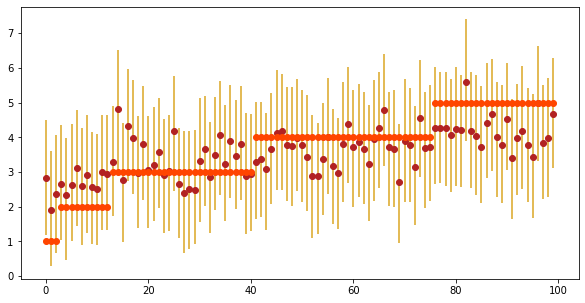

In [22]:
def ci_df(self, df):
    fig, ax = plt.subplots(figsize=(10,5))
    self.ci(row_inds=df.user_id, col_inds=df.item_id, plot=True, zorder=0, ax=ax, 
       c='firebrick', ecolor='goldenrod')
    ax.scatter(range(len(df)), df.rating, c='orangered', zorder=1)
    plt.show()

ci_df(df_hist['model'][0], df_train.sample(n=100).sort_values('rating'))

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

1 0.5


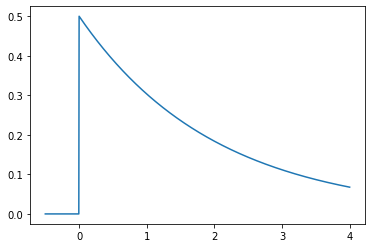

2 8


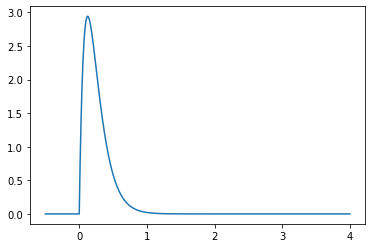

1 0.08


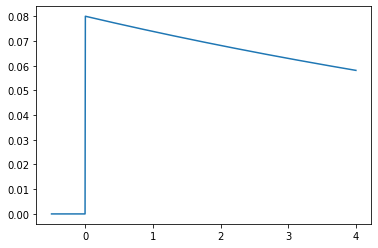

In [23]:
xrange = np.linspace(-0.5,4,1000)

a = 1
b = 0.5*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 2
b = 4*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
plt.show()

a = 1
b = 0.08*a
y = stats.gamma.pdf(xrange, a=a, scale=1/b)
print(a, b)
plt.plot(xrange, y)
# plt.axvline(((a-1)/b/(a-1)))
plt.show()

In [24]:
raise ValueError

ValueError: 

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 